In [3]:
import numpy
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time 
from torchvision import datasets, transforms
from torch import nn, optim

In [4]:
transform = transforms.ToTensor() #definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte de treino do Dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # Carrega parte para validação do Dataset
valloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

100.0%
100.0%
100.0%
100.0%


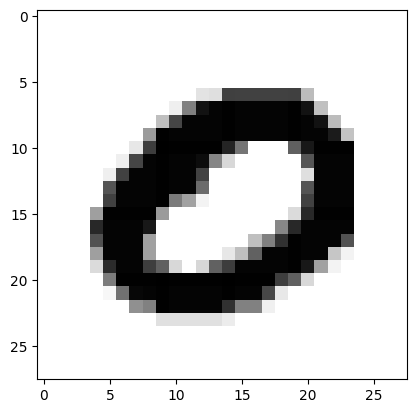

In [33]:
imagens, etiquetas = next(iter(trainloader))
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')
plt.show()

In [7]:
print(imagens[0].shape) # Verifica a dimensão do tensor de cada imagem
print(etiquetas[0].shape) # Verifica a dimensão do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])

torch.Size([1, 28, 28])
torch.Size([])


torch.Size([])

In [9]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neuronios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neuronios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neuronios que se ligam a 10
        # paar a camada de sida não é necessario definir nada pois só precisamnos pegar o output da camada interna 2

    def forwerd(self, X):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para camada interna 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
        X = F.relu(self.linear(X)) # função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) # dados utilizados para calcular perda

In [ ]:
def treino(modelo, trainloader, device):
    
    otimizador = optim.SGD(modelo.parameters(), lr=0.001, momentum=0.5) # Definindo a politica de atualização dos pesos e da bias
    inicio = time() # Iniciando a contagem do tempo de treino
    
    criterio = nn.NLLLoss() # Definindo o critério para calcular a perda
    EPOCHS = 10 # Definindo o número de épocas que o modelo irá treinar
    modelo.train() # Definindo o modelo para treino
    
    for epoch in range(EPOCHS):
        perda_acumulada = 0 # Definindo a perda acumulada para cada época
        
        for imagens, etiquetas in trainloader: # Iterando sobre o dataset de treino
            
            imagens = imagens.view(imagens.shape[0], -1) # Redimensionando as imagens para o formato de vetor de 28x28 para ficarem compatíveis com a camada de entrada
            otimizador.zero_grad() # Zerando os gradientes por conta do cliclo anterior
            
            output = modelo(imagens.to(device)) # Colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # Calculando a perda da epoch em questão
            
            perda_instantanea.backward() # Calculando os gradientes
            
            otimizador.step() # Atualizando os pesos e bias
            
            perda_acumulada += perda_instantanea.item() # Acumulando a perda da epoch em questão
            
        else:
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader))) # Imprimindo a perda da epoch em questão
    
    print("\nTempo de treino (em minutos) = ", (time()-inicio)/60) # Imprimindo o tempo de treino em minutos



In [ ]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0 # Definindo as variáveis para contar as predições corretas e todas as predições
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784) # Redimensionando a imagem para o formato de vetor de 28x28 para ficarem compatíveis com a camada de entrada
            # Desativar o autograd para acelerar o processo de validação. Grafos computacionais dinâmicos tem um curto alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device)) # Colocando os dados no modelo
                
            ps = torch.exp(logps) # Calculando a probabilidade de cada classe
            probab = list(ps.cpu().numpy()[0]) # Convertendo para numpy e pegando a probabilidade de cada classe
            etiqueta_pred = probab.index(max(probab)) # Pegando a classe com maior probabilidade
            etiqueta_certa = etiquetas.numpy()[i] # Pegando a classe correta
            
            if(etiqueta_certa == etiqueta_pred): # Verificando se a predição foi correta
                conta_corretas += 1
            conta_todas += 1
            
    print("Total de imagens: ", conta_todas) # Imprimindo o total de imagens
    print("\nPrecisão do modelo = {:.2f}%".format((conta_corretas/conta_todas)*100)) # Imprimindo a precisão do modelo

In [ ]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Definindo o dispositivo de processamento
modelo.to(device) # Colocando o modelo no dispositivo de processamento